<a href="https://colab.research.google.com/github/gcheoyh/toy-transfer-learning-eg/blob/main/transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Train MNIST Classifier

In [53]:
import tensorflow as tf
from tensorflow.keras import layers, models, Model, optimizers
import tensorflow_datasets as tfds
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# load mnist
(x_train, y_train), (x_test, y_test) = datasets.mnist.load_data(path='mnist.npz')
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# # reserve some training samples as holdout set
x_val = x_train[50000:, :, :, :]
y_val = y_train[50000:]
x_train = x_train[:50000, :, :, :]
y_train = y_train[:50000]

11493376/11490434 [==============================] - 0s 0us/step


In [85]:
train, test = tfds.load('mnist', split=['train', 'test'], shuffle_files=False, as_supervised=True)

# convert to numpy format
x_train = list(map(lambda x: x[0].numpy(), train))
y_train = list(map(lambda x: x[1].numpy(), train))

# continue from here

<PrefetchDataset shapes: ((28, 28, 1), ()), types: (tf.uint8, tf.int64)>


x_train: (50000, 28, 28, 1), x_val: (10000, 28, 28, 1), x_test: (10000, 28, 28, 1)
y_train: (50000,), y_val: (10000,), y_test: (10000,)


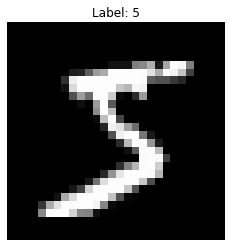

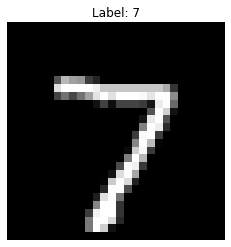

In [ ]:
# check data
print(f'x_train: {x_train.shape}, x_val: {x_val.shape}, x_test: {x_test.shape}')
print(f'y_train: {y_train.shape}, y_val: {y_val.shape}, y_test: {y_test.shape}')

# display single image from x_train and x_test
plt.figure()
plt.imshow(x_train[0, :, :, :].reshape(28, 28), cmap='gray')
plt.axis('off')
plt.title(f'Label: {y_train[0]}')
plt.show()

plt.figure()
plt.imshow(x_test[0, :, :, :].reshape(28, 28), cmap='gray')
plt.axis('off')
plt.title(f'Label: {y_test[0]}')
plt.show()

In [ ]:
cnn = models.Sequential()
cnn.add(layers.Conv2D(filters=32, kernel_size=3, input_shape=(28, 28, 1))) # conv first layer
cnn.add(layers.BatchNormalization())
cnn.add(layers.MaxPooling2D((2,2)))
cnn.add(layers.Flatten())
cnn.add(layers.Dense(1024, activation='relu'))
cnn.add(layers.BatchNormalization())
cnn.add(layers.Dropout(0.3))
cnn.add(layers.Dense(10, activation='softmax'))

print(cnn.summary())

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_2 (Batch (None, 26, 26, 32)        128       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 5408)              0         
_________________________________________________________________
dense_20 (Dense)             (None, 1024)              5538816   
_________________________________________________________________
batch_normalization_3 (Batch (None, 1024)              4096      
_________________________________________________________________
dropout_27 (Dropout)         (None, 1024)             

In [ ]:
# compile model
opt = optimizers.Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999)
loss = losses.SparseCategoricalCrossentropy(from_logits=False) # using softmax layer
cnn.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

In [ ]:
# train model with early stopping on val loss
print('Training model')
callback = EarlyStopping(monitor='val_loss', patience=3, mode='auto', restore_best_weights=True)
hist = cnn.fit(x_train, y_train, batch_size=32, epochs=30, validation_data = (x_val, y_val), callbacks=[callback])

Epoch 1/30
1563/1563 [==============================] - 7s 4ms/step - loss: 0.3524 - accuracy: 0.8949 - val_loss: 0.1016 - val_accuracy: 0.9719
Epoch 2/30
1563/1563 [==============================] - 7s 4ms/step - loss: 0.1062 - accuracy: 0.9687 - val_loss: 0.0757 - val_accuracy: 0.9789
Epoch 3/30
1563/1563 [==============================] - 7s 4ms/step - loss: 0.0781 - accuracy: 0.9766 - val_loss: 0.0628 - val_accuracy: 0.9799
Epoch 4/30
1563/1563 [==============================] - 7s 4ms/step - loss: 0.0531 - accuracy: 0.9837 - val_loss: 0.0606 - val_accuracy: 0.9828
Epoch 5/30
1563/1563 [==============================] - 7s 4ms/step - loss: 0.0426 - accuracy: 0.9876 - val_loss: 0.0563 - val_accuracy: 0.9837
Epoch 6/30
1563/1563 [==============================] - 7s 4ms/step - loss: 0.0326 - accuracy: 0.9899 - val_loss: 0.0566 - val_accuracy: 0.9843
Epoch 7/30
1563/1563 [==============================] - 7s 4ms/step - loss: 0.0257 - accuracy: 0.9925 - val_loss: 0.0501 - val_accuracy:

In [48]:
# test on test set to make sure it works
print('Testing model')
results = cnn.evaluate(x_test, y_test, batch_size=128)
print(f'Test loss: {results[0]:.4f}, test acc: {results[1]:.4f}')

Testing model
79/79 [==============================] - 0s 3ms/step - loss: 0.0408 - accuracy: 0.9870
Test loss: 0.0408, test acc: 0.9870


# Retrieve EMNIST Letters Dataset

In [52]:
(x_train, y_train), (x_test, y_test) = datasets.EMNIST.load_data(path='emnist.npz')


AttributeError: ignored